In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



### Load the dataset

In [ ]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


### Dataset size and examples

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_dataset[0][1]

5

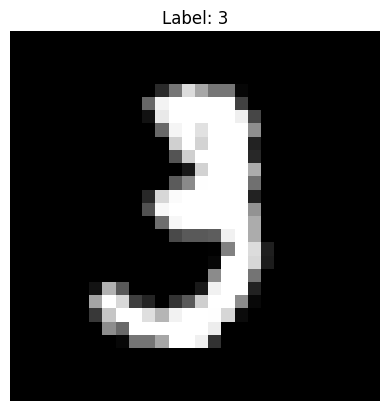

In [ ]:
# Get one example from the dataset
example_image, example_label = train_dataset[10]

# Convert the image tensor to a NumPy array for visualization
example_image_np = example_image.squeeze().numpy()

# Plot the image with its label
plt.imshow(example_image_np, cmap='gray')
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

In [ ]:
# Get the size of the dataset
dataset_size = len(train_dataset)

# Extract labels for the entire dataset
labels = [label for _, label in train_dataset]

# Count the occurrences of each digit
label_counts = Counter(labels)

# Convert the counts to a DataFrame for better readability
label_distribution = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
label_distribution.index.name = 'Digit'
label_distribution = label_distribution.sort_index()

# Print the dataset size and label distribution
print(f"Size of the dataset: {dataset_size}")
print("\nDistribution of digits in each class:")
print(label_distribution)

Size of the dataset: 60000

Distribution of digits in each class:
       Count
Digit       
0       5923
1       6742
2       5958
3       6131
4       5842
5       5421
6       5918
7       6265
8       5851
9       5949


### Define the model

In [ ]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: 32 x 28 x 28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Output: 64 x 28 x 28
        self.pool = nn.MaxPool2d(2, 2)  # Output: 64 x 14 x 14
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 14 * 14)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Train the model

In [ ]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DigitRecognizer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.1430
Epoch [2/5], Loss: 0.0414
Epoch [3/5], Loss: 0.0252
Epoch [4/5], Loss: 0.0182
Epoch [5/5], Loss: 0.0108


### Evaluate the model

In [ ]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 98.74%


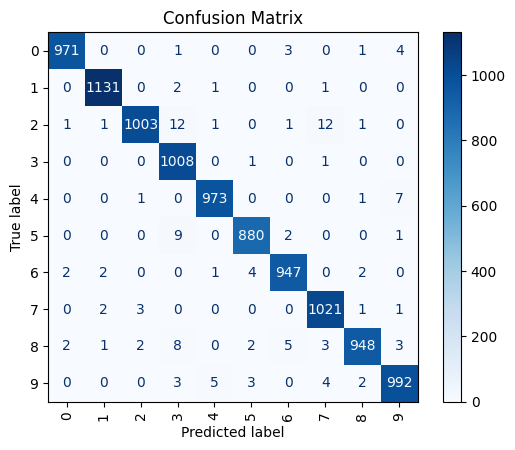

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()